Content:
 - [Part 0. Background](#Part-0.-Background)
 - [Part 1. Data loading and checking](#Part-1.-Data-loading-and-checking)
 - [Part 2. Exploratory data analysis](#Part-2.-Exploratory-data-analysis)
   - [DAU](#Daily-active-users)
   - [Retention](#Retention)
   - [Time gap between first and second event](#Average-time-between-first-and-second-event?)
   - [Users, that left after first action](#Amount-of-users,-who-left-after-1st-building?)
 - [Part 3. Statistical analysis](#Part-3.-Statistical-analysis)
 - [Conclusion and general recommendations](#Conclusion-and-general-recommendations:)

Link to Dashboard - https://public.tableau.com/profile/philip.artemenkov#!/vizhome/SpaceBrothersreport/Dashboard2

Link to Report - https://drive.google.com/file/d/1Xb5-8pUb-7ENbIvfrXF0Mti0mbIp7Hxt/view?usp=sharing

# Part 0. Background

We have data on events for the mobile game Space Brothers. Players have to create their own space programs and try to colonize the galaxy. <p>
The dataset contains data on the first users of the app — the cohort of users who began playing the game between May 4 and 10, inclusive. <p>
    The dataset contains data on users in the first stage of the game. To reach the second stage, they need to do one of the following:

- Defeat the first boss
- Build an orbital satellite-assembly system

<b>Research question:</b> What monetization strategy should be used? For now, showing ads on the screen where the user selects the type of objects to be constructed is proposed

Additional important info:
- Game genre: Strategy
- Type of game: Social Multiplayer

There are 4 most popular monetization strategies for a F2P mobile games, that can be combined together:
 - Advertising (most common and used in our game)
 - In-app purchases (currency, boosters, visuals, etc.)
 - Subscriptions
 - "Paid sister"
 
Source: https://sweetpricing.com/blog/2016/06/free-to-play-monetization/

# Part 1. Data loading and checking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import math as mth
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('seaborn-whitegrid') 
sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', -1)

### 1.1. Users data

In [2]:
users_data = pd.read_csv('/datasets/user_source_us.csv')

In [3]:
users_data.head()

,user_id,event_date,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,google_play_ads
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05,youtube_channel_network
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05,facebook_ads


In [4]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 3 columns):
user_id       13576 non-null object
event_date    13576 non-null object
source        13576 non-null object
dtypes: object(3)
memory usage: 318.3+ KB


In [5]:
users_data['event_date'] = users_data['event_date'].astype('datetime64')

In [6]:
users_data.describe()

,user_id,event_date,source
count,13576,13576,13576
unique,13576,7,4
top,6699926a-7a47-4f28-9337-67732a385d72,2020-05-04 00:00:00,google_play_ads
freq,1,5860,4817
first,NaN,2020-05-04 00:00:00,NaN
last,NaN,2020-05-10 00:00:00,NaN


In [7]:
users_data.duplicated().sum()

0

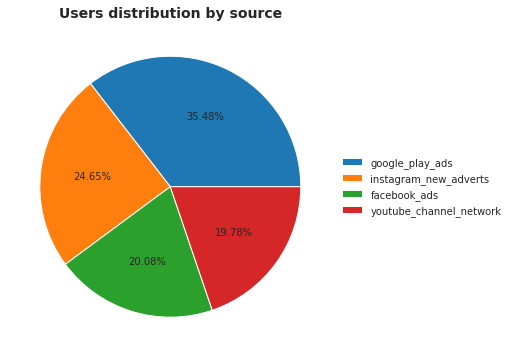

In [8]:
plt.figure(figsize=(8,6))
fig = plt.pie(users_data['source'].value_counts(),autopct='%1.2f%%')
plt.title('Users distribution by source', weight='bold', fontsize='14')
plt.legend(users_data['source'].value_counts().index,loc='center left', bbox_to_anchor=(1, 0.5));

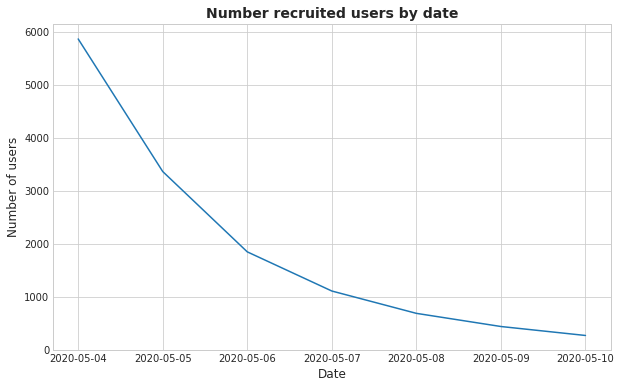

In [9]:
plt.figure(figsize=(10,6))
fig = sns.lineplot(data = users_data['event_date'].value_counts())
fig.set_title('Number recruited users by date', weight='bold', fontsize='14')
plt.xticks(users_data['event_date'].value_counts().index)#,rotation=90)
fig.set_xlabel('Date', fontsize='12')
fig.set_ylabel('Number of users', fontsize='12');

### Conclusion

We have data about 13500 unique users of our game and source of their acquisition. Google Play ad is slightly ahead in terms of recruiting users for our game, Instagram follows

### 1.2. Advertisment costs

In [10]:
ad_cost = pd.read_csv('/datasets/ad_costs_us.csv')

In [11]:
ad_cost.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [12]:
ad_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [13]:
ad_cost.describe(include='all')

,source,day,cost
count,28,28,28.000000
unique,4,7,NaN
top,youtube_channel_network,2020-05-08,NaN
freq,7,4,NaN
mean,NaN,NaN,271.556321
std,NaN,NaN,286.867650
min,NaN,NaN,23.314669
25%,NaN,NaN,66.747365
50%,NaN,NaN,160.056443
75%,NaN,NaN,349.034473


In [14]:
ad_cost.duplicated().sum()

0

In [15]:
ad_cost['cost'].sum()

7603.576986788022

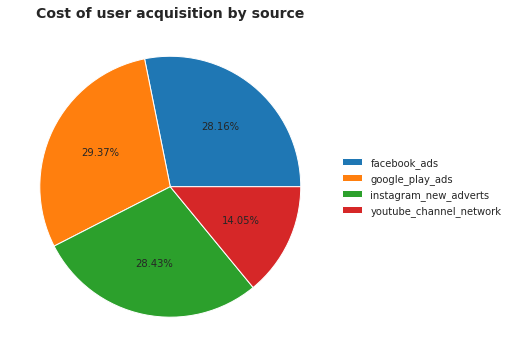

In [16]:
plt.figure(figsize=(8,6))
fig = plt.pie(ad_cost.groupby('source')['cost'].sum(),autopct='%1.2f%%')
plt.title('Cost of user acquisition by source', weight='bold', fontsize='14')
plt.legend(ad_cost.groupby('source')['cost'].sum().index,loc='center left', bbox_to_anchor=(1, 0.5));

In [17]:
ad_cost_grouped = ad_cost.groupby(['day','source'])['cost'].sum().reset_index()

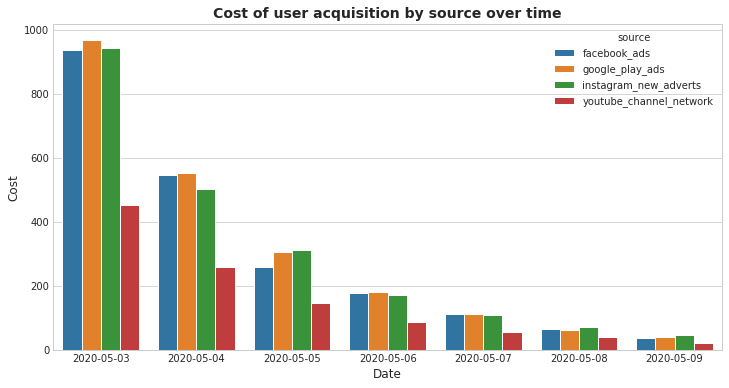

In [18]:
plt.figure(figsize = (12,6))
fig = sns.barplot(x='day',y='cost', data=ad_cost_grouped, hue = 'source')
fig.set_title('Cost of user acquisition by source over time', weight='bold', fontsize='14')
fig.set_xlabel('Date', fontsize='12')
fig.set_ylabel('Cost', fontsize='12');

### Conclusion

 - Over a week, we spend almost equal amount of money to recruit users from Facebook, Google Play and Instagram, and slightly less to recruit from Youtube
 - We can see, that amount of users recruited is in direct correlation with amount of money we spend to acquire them, with 1 day lag

### 1.3. Events

In [19]:
events  = pd.read_csv('/datasets/events_us.csv')

In [20]:
events.tail()

,event_datetime,event,building_type,user_id,project_type
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN
135639,2020-06-05 12:32:49,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN


In [21]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB


In [22]:
events['event_datetime'] = events['event_datetime'].astype('datetime64')

In [23]:
events.describe(include='all')

,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 08:39:32,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127957,59325,22,1866
first,2020-05-04 00:00:01,NaN,NaN,NaN,NaN
last,2020-06-05 12:32:49,NaN,NaN,NaN,NaN


In [24]:
events.duplicated().sum()

1

In [25]:
events[events.duplicated(keep=False)]

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


In [26]:
events.drop_duplicates(inplace=True)

In [27]:
events['event'].value_counts(normalize=True)

building            0.943357
finished_stage_1    0.042886
project             0.013757
Name: event, dtype: float64

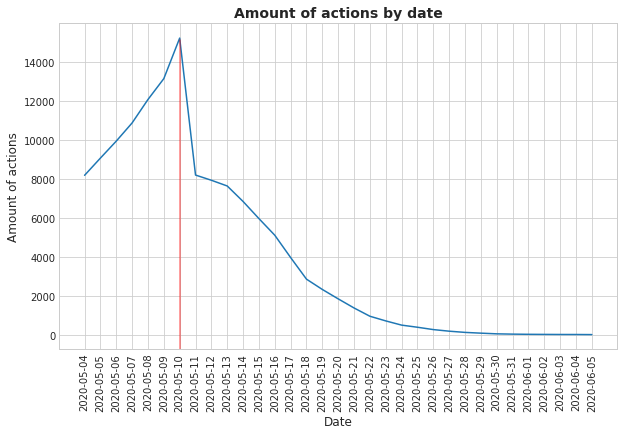

In [28]:
plt.figure(figsize=(10,6))
fig = sns.lineplot(data = events['event_datetime'].dt.date.value_counts())
fig.set_title('Amount of actions by date', weight='bold', fontsize='14')
plt.xticks(events['event_datetime'].dt.date.value_counts().index,rotation=90)
fig.set_xlabel('Date', fontsize='12')
fig.set_ylabel('Amount of actions', fontsize='12')
plt.axvline(x='2020-05-10',ymax = 0.95, color = 'red', alpha=0.5);

Average amount of building screen action per user

In [29]:
events[events['event'] == 'building'].groupby('user_id')['event'].count().mean()

9.425162050677667

### Conclusion

- We have data about 135000 users actions thruout a month from 04-05-2020 to 04-06-2020. 
- The most amount of actions were performed on 10 of May'20, and then started to go down almost reaching 0 in 30d period. 
- Such activity could be explained by fact, that by this most of the users got into core game mechanics and liked it
- 94% of all actions are building type, which means that idea of showing advertizing on building screen is a good idea, since users will saw it quite often

# Part 2. Exploratory data analysis

Amount of users, who passed stage 1, by any possible conditions

In [30]:
users_passed_stage_1 = events[events['event'] == 'finished_stage_1']['user_id']
users_passed_stage_1.nunique() 

5817

Share of users, who passed stage 1, by any possible conditions

In [31]:
users_passed_stage_1.nunique() / events['user_id'].nunique()

0.42847672362993516

Amount of users, who passed stage 1 by building orbial satelite system

In [32]:
users_build_satelite = events[events['event'] == 'project']['user_id']
users_build_satelite.nunique()

1866

Share of users, who passed stage 1 by building orbial satelite system

In [33]:
users_build_satelite.nunique() / users_passed_stage_1.nunique()

0.32078390923156264

So, about 43% of users passed stage 1, out of this users 32% passed by building satellite orbital assembly, other 2/3 of users passed by defeating boss

Average amount of events per user

In [34]:
events.groupby('user_id')['event'].count().mean()

9.991087212728344

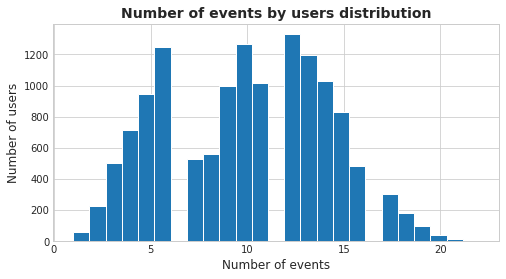

In [35]:
plt.figure(figsize=(8,4))
fig = events.groupby('user_id')['event'].count().hist(bins=25)
plt.title('Number of events by users distribution', weight='bold', fontsize='14')
fig.set_xlabel('Number of events', fontsize='12')
fig.set_ylabel('Number of users', fontsize='12');

In [36]:
events[events['user_id'].isin(users_passed_stage_1)].groupby('user_id')['event'].count().mean()

11.770500257864878

In [37]:
events[events['user_id'].isin(users_build_satelite)].groupby('user_id')['event'].count().mean()

14.64790996784566

Average amount of actions per users is 10. 

Based on average amount of actions per user, it seems that we have 4 groups of users: 
 - early leavers; 
 - those, who defeated boss or close to it;
 - those, who build satellite orbital assembly or close to it
 - hard core games, that try every action in the game

### Daily active users

In [38]:
events['date'] = events['event_datetime'].dt.date
dau = events.groupby('date')['user_id'].nunique().reset_index()
print('On average we had {} daily active users'.format(int(dau.mean())))

On average we had 2884 daily active users


Average actions per date

In [39]:
events.groupby('date')['event'].count().mean()

4110.272727272727

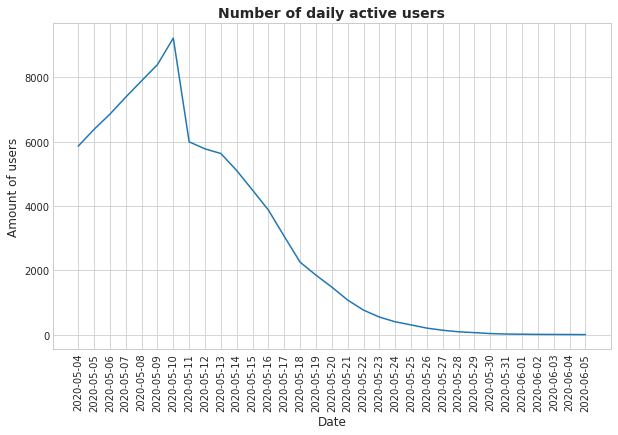

In [40]:
plt.figure(figsize=(10,6))
fig = sns.lineplot(data=dau, x ='date', y = 'user_id')
fig.set_title('Number of daily active users', weight='bold', fontsize='14')
fig.set_xlabel('Date', fontsize='12')
fig.set_ylabel('Amount of users', fontsize='12')
plt.xticks(dau['date'],rotation=90);

As well as in amount of events, most amount of active users where on 10 of May'20

### Retention

In [41]:
events = pd.merge(events, users_data, how='left', on='user_id')
events.head()

,event_datetime,event,building_type,user_id,project_type,date,event_date,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020-05-04,youtube_channel_network
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,2020-05-04,facebook_ads
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,2020-05-04,instagram_new_adverts
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,2020-05-04,facebook_ads
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,2020-05-04,google_play_ads


In [42]:
first_action = events.groupby('user_id')['event_datetime'].min().reset_index()
first_action.columns = ['user_id','first_action']
events = pd.merge(events, first_action, how='left', on='user_id')
events.head()

,event_datetime,event,building_type,user_id,project_type,date,event_date,source,first_action
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020-05-04,youtube_channel_network,2020-05-04 00:00:01
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,2020-05-04,facebook_ads,2020-05-04 00:00:03
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,2020-05-04,instagram_new_adverts,2020-05-04 00:00:16
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,2020-05-04,facebook_ads,2020-05-04 00:00:16
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,2020-05-04,google_play_ads,2020-05-04 00:00:35


In [43]:
events['first_action'] = events['first_action'].astype('datetime64[D]')
events['datediff_reg_to_first_action'] = (events['event_date'] - events['first_action'] ) / np.timedelta64(1, 'D')
day_0_retention = (events['user_id'].nunique() / events[events['datediff_reg_to_first_action'] == 0]['user_id'].nunique()) * 100
day_0_retention

100.0

We can say, that we have 100% day 0 retention rate, which is could be considered as quite good result

In [44]:
events['first_action'] = pd.to_datetime(events['first_action']).dt.normalize()
events['date'] = pd.to_datetime(events['date']).dt.normalize()
events['lifetime'] = ((events['date'] - events['first_action']) / np.timedelta64(1, 'D')).round().astype(int)

In [45]:
cohorts = events.groupby(['first_action','lifetime'])['user_id'].nunique().reset_index()
initial_amount = cohorts[cohorts['lifetime'] == 0][['first_action','user_id']]
initial_amount = initial_amount.rename(columns={'user_id':'cohort_users'})
cohorts = cohorts.merge(initial_amount, on='first_action')
cohorts['retention'] = cohorts['user_id'] / cohorts['cohort_users']
cohorts['retention']
pivot = cohorts.pivot_table(columns = 'lifetime',index='first_action', values='retention', aggfunc='sum')
pivot[[0,1,7,14,30]]

lifetime,0,1,7,14,30
first_action,,,,,
2020-05-04,1.0,0.515529,0.465529,0.145051,0.000341
2020-05-05,1.0,0.536447,0.451056,0.134186,NaN
2020-05-06,1.0,0.519762,0.434759,0.116405,0.000541
2020-05-07,1.0,0.507665,0.390442,0.095582,NaN
2020-05-08,1.0,0.482558,0.376453,0.082849,NaN
2020-05-09,1.0,0.479545,0.381818,0.104545,NaN
2020-05-10,1.0,0.254613,0.369004,0.110701,NaN


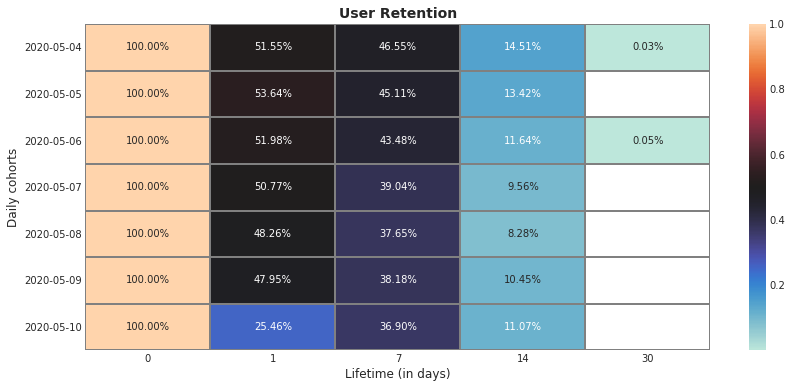

In [46]:
plt.figure(figsize=(14, 6))
fig = sns.heatmap(pivot[[0,1,7,14,30]], annot=True, fmt='.2%', linewidths=1, linecolor='gray',  cmap='icefire') 
fig.set_yticklabels(pivot.index.strftime('%Y-%m-%d'))
fig.set_title('User Retention', weight='bold', fontsize='14')
fig.set_xlabel('Lifetime (in days)', fontsize='12')
fig.set_ylabel('Daily cohorts', fontsize='12');

In [47]:
finished_stage_1_slice = events[events['event'] == 'finished_stage_1']
(finished_stage_1_slice['date'] - finished_stage_1_slice['first_action']).mean()

Timedelta('11 days 19:24:13.739040')

- We have 100% retention rate for day 0, which is quite good. For day 1 we have about 50% rate retention, except for users who joined on 10 May'20. 
- 2 weeks retention falls off significantly, average level is about 10%. 
- In order to finish stage 1, on average it requires about 11 days and 19 hours. So it seems, that drop off in 14 days retention is explained by fact that users passed major part of game, got familiar with its features and gameplay and get tired of it. Here we have opportunity to introduce new paid mechanics, that both will keep some users in game and bring us revenue

### Potential area for adding boosters(another source of monetization):
### Average time between first and second event?

In [48]:
events_sorted = events.sort_values(by=['user_id','event_datetime'])
first_event = events_sorted.groupby('user_id')['event_datetime'].min().reset_index()

In [49]:
second_event = events_sorted[~events_sorted['event_datetime'].isin(first_event['event_datetime'])].groupby('user_id')['event_datetime'].min().reset_index()

In [50]:
two_first_events = pd.merge(first_event, second_event, on ='user_id', how='left')

In [51]:
two_first_events['datediff'] = ((two_first_events['event_datetime_y'] - two_first_events['event_datetime_x'])/ np.timedelta64(1, 'h')).round()

In [52]:
two_first_events['datediff'].describe()

count    13517.000000
mean     34.206777   
std      31.892905   
min      0.000000    
25%      10.000000   
50%      24.000000   
75%      49.000000   
max      225.000000  
Name: datediff, dtype: float64

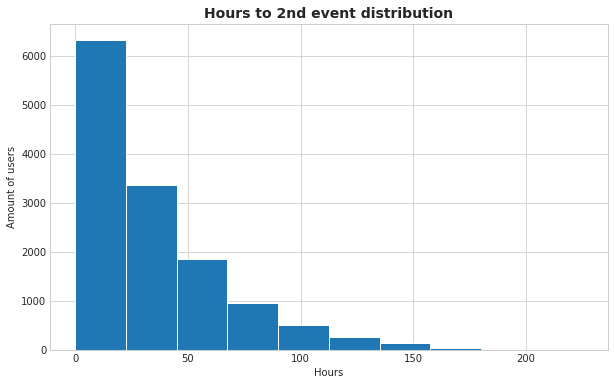

In [53]:
plt.figure(figsize=(10,6))
two_first_events['datediff'].hist()
plt.title('Hours to 2nd event distribution', weight='bold', fontsize='14')
plt.xlabel('Hours')
plt.ylabel('Amount of users');

### Amount of users, who left after 1st building?

In [54]:
two_first_events[two_first_events['event_datetime_y'].isna()]['user_id'].count() / events['user_id'].nunique() * 100

0.43459045374189753

There are potential are for introdusing bootsers in game:
- About 25% of all users performed second action in 10 hours or less after first one. This could be a signal that users are ready to consume content faster, so we can propose them payable instruments to do so
- On the other hand, there are about 50% of users, who performed second action 24 or more hours or more after first one. It seems that they are less involved in game procces, there are many possible explanations for that, but one of them is that they didn't find unique content for them, so it could be another opportunity for us to introduce unique content that they consume after paying
- Only half percent of users left after first action in game, which is quite good, there is no particular possibilities to work with them and trying to bring them back

## Conclusion

1) Genreal performance parameters:
    - On average, we have 2884 daily active users and they perform 10 actions
    - 42% users finished stage 1, by any condition
    - Out of this users, 32% passed by building satellite orbital assembly,  rest of users passed by defeating boss
    - 0.5% of users left the game after first action
    - It takes about 11 and half days to finish stage 1, for average user
    - We have 100% day 0 retention, but less that 0.5% day 30 retention. It seems that major decreased is happening between first and second week, when users finish first stage, so they start leaving
2) Monetization:
    - On average, user see building screen about 9.4 times. Considering number of active daily users and assuming 1% CTR (lower that average) and 0.3 cost per click, we can expect to have about 81 dollars income per day (2884*9.4*0.01*0.3) and about 2439 dollars per month, which is not going to cover our costs to users recruitment
    - Based on this, we can propose several additional options of monetization to be considered
        - Rewarded ads - we can introduce some pieces of content, non impacting on game progress, like visuals, that will be available only after watching an ad. This could be an addition to the our original strategy thru in-app advertizing 
        - In-app purchases. There are several possible options, we can offer boosters for those, who spend less that 10 hours between first and second actions, they seem to be involved in game, and in order to achive a goal (finish stage 1) they might be ready to pay. Another option, is group of users who had significant gap between first and second action, more than 24 hours, so maybe by introdusing option to finish level faster by paying they going to be more satisfied with game and stay longer

# Part 3. Statistical analysis

###  3.1 Test a hypothesis on the difference in completion time between users who finish the stage by building the assembly and those who do so by beating the boss.

First, we going to chech if completion time is distributed normaly by applying Shapiro-Wilk test:
   - H0: completion time is distributed normaly
   - H1: Distribution of completion time parameter is not normal
   - alpha level: 0.05

In [55]:
completion_time = events[['user_id', 'event','first_action','date']]
completion_time = completion_time[completion_time['event'] =='finished_stage_1']
completion_time['completion_time'] = (completion_time['date'] - completion_time['first_action']) / np.timedelta64(1, 'h')
ALPHA = 0.05
results = st.shapiro(completion_time['completion_time'])
p_value = results[1]
print('p-value: ', p_value)
if (p_value < ALPHA): 
    print("Null hypothesis rejected: the distribution is not normal")
else:
    print("Failed to reject the null hypothesis: the distribution seems to be normal")

p-value:  3.318088250613154e-26
Null hypothesis rejected: the distribution is not normal


So, due to fact that distribution of completion time is not normal we going to perform a Mann-Whitney statistical test based on following assumptions:
 - H0: There is no difference in completion time between users who finished by defeating the boss and those who build the assembly
 - H1: There is statistical difference in completion time between those two groups
 - alpha: 0.05, since its a regual statistical test, we don't need higher level of precision

In [56]:
completed_by_building = completion_time[completion_time['user_id'].isin(users_build_satelite)]['completion_time']
completed_by_defeating_boss = completion_time[~completion_time['user_id'].isin(users_build_satelite)]['completion_time']
results = st.mannwhitneyu(completed_by_building, completed_by_defeating_boss)
print('p-value: ', results.pvalue)
if (results.pvalue < ALPHA):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference") 

p-value:  2.3933051792268363e-105
Null hypothesis rejected: the difference is statistically significant


In [57]:
print(completed_by_building.mean(), completed_by_defeating_boss.mean())

321.5176848874598 265.4031890660592


Based on results of statistical test, we can say that there is a statistical difference in completion time between users who finish the stage by building the assembly and those who do so by beating the boss. On average, building assembly is taking significanlty longer than defeating boss

### 3.2 Test a hypothesis on the difference in completion time between users, who were acquired from different channels

From previous test we know that completion time is distributed not normaly, so there is no need to run a test again, so we going to test following hypothesis and perform Kruskal test:
   - H0: There is no significant differences in completion time for users that joined from different sources 
   - H1: Users who were acquired from different channels have differences in completion time
   - alpha: 0.05

In [58]:
completion_time_by_source = events[['user_id', 'event','first_action','date','source']]
completion_time_by_source = completion_time_by_source[completion_time_by_source['event'] =='finished_stage_1']
completion_time_by_source['completion_time'] = (completion_time_by_source['date'] - completion_time_by_source['first_action']) / np.timedelta64(1, 'h')

#st.f_oneway()
results = st.kruskal(completion_time_by_source['completion_time'][completion_time_by_source['source']=='instagram_new_adverts'],
              completion_time_by_source['completion_time'][completion_time_by_source['source']=='facebook_ads'],
              completion_time_by_source['completion_time'][completion_time_by_source['source']=='youtube_channel_network'],
              completion_time_by_source['completion_time'][completion_time_by_source['source']=='google_play_ads'])
print('p-value: ', results.pvalue)
if (results.pvalue < ALPHA):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference") 

p-value:  0.7508827405244661
Failed to reject the null hypothesis: we can't make conclusions about the difference


Based on results of statistical test we can say that there is no difference in users that coming from different sources in terms of time to complete stage 1. This could tell us, that our game have same complexity curve and its working for all users. Since we don't have any boosters, we can expect that users will spend same amount of time to complete levels

### 3.3 Test a hypothesis on the difference in day 7 retention rate between users from different chanels

We are going to compare day 7 retention rate for 4 groups of users, that where acquired thru different channels. We are going to run a proportions test for each possible pair of chanel with following hypothesis:
    - H0: There is no differnce between users that came from different sources in terms of day 7 retention rate
    - H1: Users that where acquired from different sources have different level of day 7 retention rate
    - alpha: 0.05

In [59]:
conv_by_source = events.groupby(['source','lifetime'])['user_id'].nunique().reset_index()
conv_by_source = conv_by_source[(conv_by_source['lifetime'] == 0) |(conv_by_source['lifetime'] == 7)]

In [60]:
conv_by_source_original = conv_by_source[conv_by_source['lifetime'] == 0].drop('lifetime', axis=1)
conv_by_source_original.columns = ['source','total_amount']
conv_by_source_7_day = conv_by_source[conv_by_source['lifetime'] == 7].drop('lifetime', axis=1)
conv_by_source_7_day.columns = ['source','day7_amount']
conv_by_source = pd.merge(conv_by_source_original,conv_by_source_7_day, on = 'source')
conv_by_source['proportion'] = conv_by_source['day7_amount'] / conv_by_source['total_amount']
conv_by_source

,source,total_amount,day7_amount,proportion
0,facebook_ads,2726,1219,0.447175
1,google_play_ads,4817,2152,0.446751
2,instagram_new_adverts,3347,1481,0.442486
3,youtube_channel_network,2686,1155,0.430007


In [61]:
conv_by_source

,source,total_amount,day7_amount,proportion
0,facebook_ads,2726,1219,0.447175
1,google_play_ads,4817,2152,0.446751
2,instagram_new_adverts,3347,1481,0.442486
3,youtube_channel_network,2686,1155,0.430007


In [62]:
def stat_test(group1,group2, alpha=0.05):
    s1 = conv_by_source[conv_by_source['source'] == group1]['day7_amount']
    s2 = conv_by_source[conv_by_source['source'] == group2]['day7_amount']
    n1 = conv_by_source[conv_by_source['source'] == group1]['total_amount']
    n2 = conv_by_source[conv_by_source['source'] == group2]['total_amount']
    z_value, p_value = proportions_ztest([s1,s2],[n1,n2])
    print('P value:',p_value,', Z value:',z_value)
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there is a significant difference between users acquired from {} and from {}".format(group1,group2))
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the proportions different between users acquired from {} and from {}".format(group1,group2))

In [63]:
for i,z in list(itertools.combinations(conv_by_source['source'].unique(), 2)):
      stat_test(i,z)

P value: [0.97159788] , Z value: [0.0356043]
Failed to reject the null hypothesis: there is no reason to consider the proportions different between users acquired from facebook_ads and from google_play_ads
P value: [0.71452127] , Z value: [0.36579069]
Failed to reject the null hypothesis: there is no reason to consider the proportions different between users acquired from facebook_ads and from instagram_new_adverts
P value: [0.20317469] , Z value: [1.27255869]
Failed to reject the null hypothesis: there is no reason to consider the proportions different between users acquired from facebook_ads and from youtube_channel_network
P value: [0.70290322] , Z value: [0.38140437]
Failed to reject the null hypothesis: there is no reason to consider the proportions different between users acquired from google_play_ads and from instagram_new_adverts
P value: [0.16137249] , Z value: [1.40047042]
Failed to reject the null hypothesis: there is no reason to consider the proportions different between u

After comparing proportions of day 7 retention between users that joined our game from different sources, we can say that there is no differnce betweem theese users, so we don't need to focus of specific source and keep atracting users from different sources 

# Conclusion and general recommendations:

- We analyzed data about 13576  unique users, that joined game from 04-05-2020 to 10-05-2020 from 4 different sources. 35% from Google play ads, 25% from Instagram ads. and about 20% for Facebook and YouTube channel each
- In order to acquire these users we spent 7603 dollars over a week period, in almost equal shares per source, with slightly less expenditures on YouTube
- These users performed about 135640 actions is our games, which allowed us to make following conclusions:
     - About 43% of users passed stage 1, out of this users 32% passed by building satellite orbital assembly, rest passed by defeating boss
     - On average users perform about 10 actions. Users, who passed stage 1 by building satellite do about 15 actions on average. In addition to this, statistical test proved that there is a significant difference in completion time between those, who finish by defeating boss compared to those, who build satellite system. It takes significantly longer for the last group.
     - On average we had 2884 daily active users
     - Only 0.5% of users left the game after first action
     - It takes about 11 and half days to finish stage 1, for average user
     - We have 100% day 0 retention, but less that 0.5% day 30 retention. It seems that major decreased is happening between first and second week, when users finish first stage, so they start leaving. We didn't find any significant difference in day 7 conversion between users, that where acquired thru different sources.
- There is 2 possible monetization strategies to implemented in game, we can select one or combine them both:
    - In-Game Advertising. By introducing this type of monetization we can expect about 81 dollar per day income, considering that users see building screen about 9,4 times with 2884 daily active users, presumably 1% CTR and 0.3 CPC. Which will bring us about 2439 dollars per month, which is not going to cover our costs for users recruitment
    - In-Game Purchases. Its hard to evaluate possible income from this options, since we are missing a lot of necessary information (% of conversion, conversion time, LTV), but there are several options that could be implemented: rewarded ads, we can give some unique pieces of content, that don't have impact on game progress, for those who watch ads, like visuals, skins etc.) or boosters. We have 2 potential groups to sell them to - those, who rushed between 1st and 2nd buildind and did it faster than 10 hours (about 25% of users) or those, who spend 24 hours or more to proceed from 1st action to second, this might improve their involvment and performance. 
- We recommend to introduce new monetization strategies one-by-one followed by A/B test, in order to track performance. If we going to focus on in-app advertisment as monetization strategy, so we should choose retention as main KPI, because as longer user stay in app more value he generates. If we going to introduce in-app puchases, then conversion should be our main KPI.


### Documentation:
 - 1. https://sweetpricing.com/blog/2016/06/free-to-play-monetization/ - review of most common monetization strategies for free-to-play games. I took basic ideas of what strategies we can use in our game
 - 2. https://www.wordstream.com/average-ctr#:~:text=The%20average%20click%2Dthrough%20rate%20on%20AdWords%20paid%20search%20ads,considered%20an%20above%20average%20CTR
 Information on CTR, average CTR in Adwords across all industries is 1.91%. Infographic that we can use as reference to evaluate our CTR, if we going to introduce in-game ads.
 - 3. https://admob.google.com/home/resources/rewarded-ads-win-for-everyone/ - another article on monetization strategy and its advantages. Becoming more and more popular according to Google Ads Data
 - 4. https://www.devtodev.com/education/articles/en/84/25-key-metrics-to-track-user-loyalty - rather short summary on basic metrics that we need to track and calculate in order to evaluate performance of our game and quality of users. Helped with retention calculation
 - 5. https://www.deconstructoroffun.com/blog/2017/9/13/how-monetize-using-behavioural-economics another acticle on monetization strategies from behavioural point of view, with examples from market leaders. 
 - 6. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html Since completion time is not normaly distributed we needed Anova non-parametric analog to test hypothesis about difference in completion time between groups of users, that where acquired from different sources.